# Money Mule detection using Neo4j and Scikit-Learn/Tensorflow

## Dataset
Paysim is an approach using an agent-based model and some anonymized, aggregate transactional data from a real mobile money network operator to create synthetic financial data sets academics and hackers can use for exploring ways to detect fraudulent behavior.

More info here: https://www.sisu.io/posts/paysim/

https://www.kaggle.com/kartik2112/fraud-detection-on-paysim-dataset

## Mules

Money mules are defined as customers/clients that collude with fraudsters and facilitate moving money out of the network. Some of the typical activities of money mules are lending their credentials to fraudsters, send money to fraudsters in untreaceable amounts over a period of time, receive money from fraudsters and move money out of network etc.

In this dataset, some clients are labelled as mules. Our task is to train supervised ML classification models using these labelled examples and detect if there are any mules among unlabelled clients in the dataset. 

## What we do
- We will use Neo4j to load the data into a graph. 
- Preprocess the data to generate additional topological features
- Generate graph embeddings using Neo4j GDS library 
- Train a supervised classification model in Neo4j GDS library
- Train a supervised classification model using Keras/Tensorflow

## Why Graphs and Graph Embeddings

Detecting mules using abstract features such as transaction amounts, type of transactions, historical fradulent transactions ets is not effective and leads to a lot of false positives. Mules by definition are clients that collude fraudsters. There are no labelled fraudsters in the dataset. 

Here we need a method to generate a vector representation for every client based on their relationship to other clients and specifically with the clients that have potential to commit fraud. Hence, we need a graph datastructure and algorithms to generate topological features for training a classification model.


## Approach

- Load Paysim dataset into Neo4j
- Preprocess the dataset 
  - add class labels to mule examples
  - generate additional relationships to add more context
  - build additional graphy features on client nodes 
- Generate Client embeddings using
  - Node2Vec (only relationships)
- Generate Train/Test Splits
- Train a Logistic Regression model in Neo4j GDS library
    - Use k-fold cross validation to compute model metrics
    - Test model performance of all models on the test graph
    - Pick the best model and predict if there are any mules among unlabelled clients using the trained LR model
- Get embeddings from Neo4j and train a neural net using Keras and compute model metrics

In [ ]:
%%capture
%pip install graphdatascience==1.2.0 pandas seaborn
%pip install --upgrade ipywidgets

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

## Neo4j interface
 
 Wrap neo4j python driver in Neo4j DB interface class

In [ ]:
# Connect to Neo4j

url = 'neo4j+s://xxxxx.databases.neo4j.io' # set to your Neo4j instance
username = 'neo4j'
password = 'CHANGME!' # your neo4j password

AURA_DS = url.startswith('neo4j+s://') and url.endswith('.databases.neo4j.io')

In [ ]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(url, auth=(username, password), aura_ds=AURA_DS)

if not AURA_DS:
  info = gds.debug.sysInfo()
  if info.query("key == 'gdsEdition'")["value"].values[0] == "Unlicensed":
    CONCURRENCY = 4
  else:
    CONCURRENCY = int(info.query("key == 'physicalCPUs'")["value"].values[0])
  HOSTING = "(self-hosted)"
else:
  # on Aura we can us JMX...it's not a perfect heuristic, however, but ok enough
  cpus = gds.run_cypher("""
    CALL dbms.queryJmx("java.lang:type=OperatingSystem") YIELD name, attributes
    WITH attributes["AvailableProcessors"]["value"] AS cpus
    RETURN cpus
  """)
  CONCURRENCY = int(cpus["cpus"][0])
  HOSTING = "AuraDS"

print(f"Using GDS v{gds.version()} on {HOSTING} with {CONCURRENCY} CPUs")

Using GDS v2.1.5 on AuraDS with 32 CPUs


## Preprocessing & Setup

We'll prepare our graph through three (3) steps:

1. Remove any properties from previous runs of the notebook to give us a "clean slate."
2. Use the `:Mule` node Labels to set node properties we'll use as our ML labels.
3. Construct a **weighted monopartite graph** modeling how each `Client` interacted with other `Client` nodes via money transfers.

In [ ]:
# First, cleanup any properties created from previously running this notebook.
gds.run_cypher("""
    MATCH (c:Client)
    REMOVE c.fraud_risk_score
    REMOVE c.si_risk_score
    REMOVE c.is_train_data
    REMOVE c.predicted_mule_probability_n2v
    REMOVE c.predicted_mule_n2v
""")


""


### Add target property to identify Mules

In [ ]:
gds.run_cypher("""
  MATCH (c:Client) WHERE NOT c:Mule 
  SET c.is_mule = 0
  RETURN count(c) AS numNotMules
""")

,numNotMules
0,2000


In [ ]:
gds.run_cypher("""
  MATCH (c:Mule)
  SET c.is_mule = 1
  RETURN count(c) AS numMules
""")

,numMules
0,433


### Architecting the Monopartite Graph
Now we'll use the simplicity of **Cypher** to mutate our existing data model into a simplified, monopartite form with weighted edges.

The idea is to:

- Connect a pair of clients that send or receive money from others using a new `:TRANSACTS_WITH` relationship **type**

- Use categorical values for the "size" of the transfers instead of absolute values. We'll call this new node property `amountCategory`.

In [ ]:
# Bin transaction amounts into transaction "categories"
gds.run_cypher("""
    MATCH (t:Transfer) 
    WITH apoc.agg.statistics(t.amount, [0.1, 0.25, 0.5, 0.75]) as m

    MATCH (t:Transfer) 
    WITH t, m, CASE 
        WHEN t.amount <= m.`0.1` THEN toFloat(1.0)
        WHEN m.`0.1` <= t.amount <= m.`0.25` THEN toFloat(2.0)
        WHEN m.`0.25` <= t.amount <= m.`0.5` THEN toFloat(3.0)
        WHEN m.`0.5` <= t.amount <= m.`0.75` THEN toFloat(4.0)
        WHEN t.amount > m.`0.75` THEN toFloat(5.0)
        ELSE toFloat(0.0)
    END AS cat

    SET t.amountCategory = cat
    RETURN DISTINCT cat AS amountCategory, count(*) AS numberOfTransfers 
    ORDER BY cat
""")

,amountCategory,numberOfTransfers
0,1.0,1946
1,2.0,2919
2,3.0,4865
3,4.0,4865
4,5.0,4865


In [ ]:
# Create TRANSACTS_WITH relationships with transaction category as weight of the
# relationship.
gds.run_cypher("""
    CALL apoc.periodic.iterate(
    "
      MATCH (c1:Client)-[:PERFORMED]->(t:Transfer)-[:TO]->(c2:Client)
      RETURN id(c1) AS id1, id(c2) AS id2, t.amountCategory as txnCat
    ",
    "
      MATCH (c1:Client), (c2:Client) WHERE id(c1) = id1 AND id(c2) = id2
      MERGE (c1)-[:TRANSACTS_WITH {txnCat: txnCat}]->(c2)
    ",
    { batchSize: 5000, concurrency: 4, retries: 10 })
""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,4,19460,0,19460,0,0,0,{},"{'total': 4, 'committed': 4, 'failed': 0, 'errors': {}}","{'total': 19460, 'committed': 19460, 'failed': 0, 'errors': {}}",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relationshipsCreated': 0, 'nodesCreated': 0, 'propertiesSet': 0, 'relationshipsDeleted': 0, 'labelsRemoved': 0}"


## Feature Engineering

At this point, we have a **directed, weighted monopartite (homogeneous) graph**. While this sounds like a mouthful, it means:


1. All the edges have a defined **direction**. One `:Client` is the sender and the other is a receiver.

2. Our edges have **weights** in the form of our `amountCategory` values we created. Originally they were node properties, but as we folded the `:Transfer` nodes into edges, we turned the property into a **relationship property.**

3. All our nodes are of the **"same class"** (in other words, share the same Node label) representing the same thing...a `:Client`.


What we can do now is extract **features** to use as inputs to our Machine Learning model development. Some of these features we'll derive from the data itself, but some we'll derive from the **structure of the graph.**

### Feature 1: Fraud Risk Score
We'll first compute a scalar representing a "risk score" (`fraud_risk_score`) for every client based on connections to previously identified fraudulent transactions.

> Consider the case where we have some high-quality input from existing clients that report fraud or file complaints.

In [ ]:
# Our data has a `fraud` property already set on a subset of Transactions. Let's
# use it to devise a "risk score."
gds.run_cypher("""
    MATCH (c:Client)-[]->(t:Transaction { fraud:true })
    WITH count(t) as fraudtxns
    WITH apoc.coll.max(collect(fraudtxns)) as maxNum

    MATCH (c:Client)-[]->(t:Transaction { fraud:true })
    WITH c, maxNum, count(t) as fraudCount

    SET c.fraud_risk_score = toFloat(fraudCount) / maxNum

    RETURN 1000 * max(c.fraud_risk_score) AS maxScaled, 
           1000 * min(c.fraud_risk_score) AS minScaled, 
           1000 * avg(c.fraud_risk_score) AS avgScaled,
           count(c) AS numOfClientsScored
""")

,maxScaled,minScaled,avgScaled,numOfClientsScored
0,6.293266,0.629327,1.992032,502


In [ ]:
# Set fraud_risk_score = 0 for all other clients
gds.run_cypher("""
    MATCH (c:Client) WHERE NOT exists(c.fraud_risk_score)
    SET c.fraud_risk_score = 0.0
    RETURN count(c) AS numOfClientsSetToZero
""")

,numOfClientsSetToZero
0,1931


### Feature 2: Shared Identifiers Risk Score

Our hypothesis is that Clients who share **identifiers** (Phone Number, Email Address and SSN) are *most likely* to commit fraud. Conversely, we exepct the clients *not sharing* any identifiers to be *least likely* to commit fruad. 

> It is possible a phone number is shared between two clients (e.g. "householding") but a shared SSN is definitely a red flag.

**Examples**: 
- A client shares an email address with three other clients and a phone number with a different client and SSN with four clients.
- A client only shares a phone number with another client
- A client shares an SSN or tax id with three other clients
- ...

Compute **shared identifiers risk score** for all clients
- Find patterns of shared identifiers and persisting a new relationhsip between clients
- Find paiwise similarity between all clients that share identifiers 
- Use pairwise similarity score to compute weighted centrality score (**si_risk_score**)


In [ ]:
# relationship to connect clients that share one or more than one of the identifiers like SSN, Email or Phone Number
gds.run_cypher("""
    MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n)<-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
    WHERE c1.id <> c2.id
    WITH c1, c2, count(*) as cnt

    MERGE (c1)-[r:SHARED_IDENTIFIERS {count: cnt}]->(c2)
    RETURN count(r) AS numRelationshipsWritten
""")

,numRelationshipsWritten
0,1518


In [ ]:
# Drop Any existing Graphs, Pipelines, Models...

df = gds.graph.list()
for i in df["graphName"]:
  gds.graph.get(i).drop()

df = gds.beta.pipeline.list()
for i in df["pipelineName"]:
  gds.pipeline.get(i).drop()

df = gds.beta.model.list()
for info in df["modelInfo"]:
  gds.model.get(info["modelName"]).drop()

In [ ]:
# Project a graph to run similarity
G, _ = gds.graph.project("client_graph", 
                         "Client",
                         {
                             "SHARED_IDENTIFIERS": {
                                 "orientation": "NATURAL",
                                 "properties": ["count"],
                             },
                         },
                         readConcurrency=CONCURRENCY)

print(f"Created {G.name()} with {G.node_count():,} nodes, {G.relationship_count():,} relationships")

Created client_graph with 2,433 nodes, 1,518 relationships


In [ ]:
# Run Weighted Node Similarity and mutate in-memory graph
gds.nodeSimilarity.mutate(G,
                          similarityCutoff=0.05,
                          concurrency=CONCURRENCY,
                          mutateRelationshipType='SIMILAR_TO',
                          mutateProperty='score',
                          relationshipWeightProperty='count')

preProcessingMillis                                                                                                                                                                                                                                                                                                                                                                                                      0
computeMillis                                                                                                                                                                                                                                                                                                                                                                                                           14
mutateMillis                                                                                                                                                                      

In [ ]:
# Run weighted degree centrality to compute si_risk_score
gds.degree.mutate(G,
                  nodeLabels=['Client'],
                  relationshipTypes=['SIMILAR_TO'],
                  relationshipWeightProperty='score',
                  mutateProperty='si_risk_score',
                  concurrency=CONCURRENCY)

nodePropertiesWritten                                                                                                                                                                                                                                                                         2433
centralityDistribution                                                                     {'p99': 3.5503673553466797, 'min': 0.0, 'max': 4.635801315307617, 'mean': 0.27487007169335453, 'p90': 1.2409114837646484, 'p50': 0.0, 'p999': 4.491270065307617, 'p95': 2.3846263885498047, 'p75': 0.0}
mutateMillis                                                                                                                                                                                                                                                                                     0
postProcessingMillis                                                                                                           

In [ ]:
# Write shared identifiers risk scores to the database
gds.graph.writeNodeProperties(G, ['si_risk_score'], ['Client'],
                              writeConcurrency=CONCURRENCY)

writeMillis                       29
graphName               client_graph
nodeProperties       [si_risk_score]
propertiesWritten               2433
Name: 0, dtype: object

In [ ]:
# We no longer need our graph project, so let's drop it!
gds.graph.drop(G)

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   client_graph
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
#Run this to fix convert the data type of risk scores from long to floats

gds.run_cypher("""
  MATCH (c:Client)
  SET c.fraud_risk_score  = toFloat(c.fraud_risk_score)
  SET c.si_risk_score  = toFloat(c.si_risk_score)
  RETURN count(c) AS numUpdated
""")

,numUpdated
0,2433


### 3. Update `TRANSACTS_WITH` relationship

- Update the weight on the relationship with a composite score of transaction category + fraud_risk_score + si_risk_score
- This gives higher weight to relationships with known and suspected fraudsters.


In [ ]:
gds.run_cypher("""
    CALL apoc.periodic.iterate(
        "MATCH (c1:Client)-[t:TRANSACTS_WITH]->(c2:Client) RETURN c1, c2, t",
        "SET t.weight = t.txnCat + c1.fraud_risk_score + c1.si_risk_score + c2.fraud_risk_score + c2.si_risk_score",
        { batchSize: 500 }
    )
""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,39,19263,0,19263,0,0,0,{},"{'total': 39, 'committed': 39, 'failed': 0, 'errors': {}}","{'total': 19263, 'committed': 19263, 'failed': 0, 'errors': {}}",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relationshipsCreated': 0, 'nodesCreated': 0, 'propertiesSet': 19263, 'relationshipsDeleted': 0, 'labelsRemoved': 0}"


### Supervised ML: Train/Test Split

Label nodes to split Clients into Train and Test data

- Randomly splitting the dataset (80/20)
- Add new class labels to differentiate training and test data

In [ ]:
# Randomly pick 80% of clients and label them as training data
gds.run_cypher("""
    CALL apoc.periodic.iterate(
    "MATCH (c:Client) WITH collect(ID(c)) as clients 
        RETURN apoc.coll.randomItems(clients, toInteger(0.8 * size(clients))) as trainClients", 
    "UNWIND trainClients as trainClient 
        MATCH (c:Client) WHERE ID(c) = trainClient 
        SET c.is_train_data = 1", {batchSize: 10000})
""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,1,0,1,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'errors': {}}","{'total': 1, 'committed': 1, 'failed': 0, 'errors': {}}",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relationshipsCreated': 0, 'nodesCreated': 0, 'propertiesSet': 1946, 'relationshipsDeleted': 0, 'labelsRemoved': 0}"


In [ ]:
# Label the remaining clients as test data
gds.run_cypher("""
  MATCH (c:Client) WHERE NOT exists(c.is_train_data)
  SET c.is_train_data = 0
  RETURN count(c) AS cnt
""")

,cnt
0,487


In [ ]:
# Check the number of mules in train data

gds.run_cypher("""
  MATCH (c:Client) WHERE c.is_mule = 1 AND c.is_train_data = 1
  RETURN count(c) as numTrainingMules;
""")

,numTrainingMules
0,348


In [ ]:
# Check the number of mules in test data
gds.run_cypher("""
  MATCH (c:Client) WHERE c.is_mule = 1 AND c.is_train_data = 0
  RETURN count(c) AS numTestMules;
""")

,numTestMules
0,85


## Client Embeddings


In [ ]:
# Project in-memory graph with newly added relationships and node properties
G, _ = gds.graph.project('mule_graph', 
        {
          'Client': {
              'properties':{
                  'is_mule': { 'defaultValue': 0 },
                  'fraud_risk_score': { 'defaultValue':0.0 },
                  'si_risk_score': { 'defaultValue': 0.0 },
                  'is_train_data': { 'defaultValue':0 },
              },
          },
        },
        {
          'TRANSACTS_WITH':{
              'orientation': 'UNDIRECTED',
              'properties': 'weight',
              'aggregation': 'SUM',
          }
        },
        readConcurrency=CONCURRENCY)

print(f"Created {G.name()} with {G.node_count():,} nodes and {G.relationship_count():,} relationships")

Created mule_graph with 2,433 nodes and 38,346 relationships


In [ ]:
gds.fastRP.mutate(G,
                     embeddingDimension=128,
                     iterationWeights=[1.0, 0.0, 1.0, 0.25],
                     randomSeed=1337,
                     mutateProperty="frp_embedding",
                     concurrency=CONCURRENCY,
                     relationshipWeightProperty="weight")

nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                                                                                                2433
mutateMillis                                                                                                                                                                                                                                                                                                                                                                                                                                            0
nodeCount                                                                                                           

## Supervised Machine Learning 🧠 in Neo4j

We'll take the following steps to build a logistic regression machine learning model to predice labels for our nodes:

- Create a subgraph with train data
- Train a logistic regression model
- Save the model into model catalog

### 1. Projecting the Training Graph

We already have a `mule_graph` that is a projection of our **weighted  monopartite** `:Client` network that captures who transacted with whom. It contains both our test and training data.

To separate the two, we use a **subgraph projection** to derive a training and a testing graph. Subgraph projections can use property filter logic to split the original projection into multiple sub-projections! 👩‍👧‍👦

In [ ]:
# Create subgraph by filtering on `is_train_data` label
training, _ = gds.beta.graph.project.subgraph('mule_train_graph', G,
                                             'n:Client AND n.is_train_data = 1',
                                             '*')

print(f"Created subgraph {training.name()} with {training.node_count():,} nodes "
      f"and {training.relationship_count():,} relationships")

Created subgraph mule_train_graph with 1,946 nodes and 24,380 relationships


## 2. Building an Machine Learning Pipeline

Neo4j allows you to capture the steps needed to engineer features as well as test against different modeling approaches and parameters. To do so, we build what's called a **pipeline**.

A **pipeline** contains all the steps and parameters used to training and constructing a model. Pipelines are given a unique name (here we'll use `"mule-pipeline"`) and can be saved for reuse.

In [ ]:
# Logistic regression model
pipe, _ = gds.beta.pipeline.nodeClassification.create("mule-pipeline")

# A pipeline can contain pre-processing using algorithms or functions. In this
# case, let's use the Louvain community detection algorithm and Degree
# centrality to generate additional features for the model candidates.
pipe.addNodeProperty("louvain",
                     relationshipWeightProperty="weight",
                     mutateProperty="community_id",
                     concurrency=CONCURRENCY)

pipe.addNodeProperty("degree",
                     relationshipWeightProperty="weight",
                     orientation="UNDIRECTED",
                     mutateProperty="degree",
                     concurrency=CONCURRENCY)

# We'll combine our FastRP embeddings previously computed with the on-the-fly
# computation of communities.
pipe.selectFeatures([
  "frp_embedding", "si_risk_score", "fraud_risk_score", "community_id", "degree"
])

# Our pipeline will handle train/test splitting for us!
pipe.configureSplit(validationFolds=3, testFraction=0.2)

# We'll use Logistic Regression and configure ranges of hyperparameters...
if gds.version().startswith('2.1'):
  # If we're using v2.1 or newer, we can use a shorthand "range" approach and the
  # auto-tuning capabilities!
  pipe.addLogisticRegression(penalty={"range": [0.0125, 1.0]},
                           batchSize={"range": [10, 1_000]},
                           patience={"range": [1, 10]})
  meta = pipe.configureAutoTuning(maxTrials=100)
else:
  ## If we're using v2.0, we need to hand-roll our model candidates 😔
  pipe.addLogisticRegression(penalty=0.0625,
                            batchSize=10,
                            patience=1)
  pipe.addLogisticRegression(penalty=0.0625,
                            batchSize=100,
                            patience=2)
  pipe.addLogisticRegression(penalty=0.0625,
                            batchSize=100,
                            patience=3)
  meta = pipe.addLogisticRegression(penalty=1.0,
                                    batchSize=10,
                                    patience=1)

meta

name                                                                                                                                                                                                                                                                                                            mule-pipeline
nodePropertySteps    [{'name': 'gds.louvain.mutate', 'config': {'relationshipWeightProperty': 'weight', 'mutateProperty': 'community_id', 'concurrency': 32}}, {'name': 'gds.degree.mutate', 'config': {'orientation': 'UNDIRECTED', 'relationshipWeightProperty': 'weight', 'mutateProperty': 'degree', 'concurrency': 32}}]
featureProperties                                                                                                                                                                                                                                      [frp_embedding, si_risk_score, fraud_risk_score, community_id, degree]
splitConfig                                   

Before we train and build the model, we can get a memory estimate just like with other GDS algorithms and routines.

In [ ]:
estimate = pipe.train_estimate(training, nodeLabels=["Client"],
                               modelName="mule-model", targetProperty="is_mule", 
                               randomSeed=2, concurrency=CONCURRENCY,
                               metrics=['ACCURACY', 'F1_WEIGHTED', 
                                        'PRECISION(class=*)', 'RECALL(class=*)',
                                        'F1(class=*)'])

In [ ]:
model, res = pipe.train(training, nodeLabels=["Client"],
                        modelName="mule-model", targetProperty="is_mule", 
                        randomSeed=2, concurrency=CONCURRENCY,
                        metrics=['ACCURACY', 'F1_WEIGHTED', 'PRECISION(class=*)',
                                 'RECALL(class=*)', 'F1(class=*)'])
res

Node Classification Train Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

modelSelectionStats    {'modelCandidates': [{'metrics': {'RECALL_class_0': {'validation': {'avg': 0.9999999999766537, 'min': 0.9999999999766355, 'max': 0.99999999997669}, 'train': {'avg': 0.9999999999883268, 'min': 0.9999999999883178, 'max': 0.9999999999883313}}, 'RECALL_class_1': {'validation': {'avg': 0.0, 'min': 0.0, 'max': 0.0}, 'train': {'avg': 0.0, 'min': 0.0, 'max': 0.0}}, 'PRECISION_class_0': {'validation': {'avg': 0.825835744894967, 'min': 0.82466281308623, 'max': 0.8265895953597959}, 'train': {'avg': 0.8...
trainMillis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### 2. Projecting the Test Graph

We'll now use our test data and the new model to predict mule labels. Similar to how we built a subgraph for training, we'll use the same technique to quickly filter our original projection down to our test data (where `is_train_data=0`).

Once we have the projection, passing it to the model to predict the labels is easy!

In [ ]:
test_graph, _ = gds.beta.graph.project.subgraph('mule_test_graph', G,
                                                'n:Client AND n.is_train_data = 0',
                                                '*')

print(f"Created subgraph {training.name()} with {training.node_count():,} nodes "
      f"and {training.relationship_count():,} relationships")

Created subgraph mule_train_graph with 1,946 nodes and 24,380 relationships


In [ ]:
model.predict_mutate(test_graph, nodeLabels=["Client"], concurrency=CONCURRENCY,
                     mutateProperty="predicted_mule_n2v",
                     predictedProbabilityProperty="predicted_mule_probability_n2v")

Node Classification Predict Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                 974
mutateMillis                                                                                                                                                                                                                                                                                                                                            0
postProcessingMillis                                                                                                                                                                                                                                                                                                

### 3. Write predicted labels back to the database

Let's materialize the predictions back to the database so we can visualize with **Neo4j Bloom** and also check our ML performance.

In [ ]:
gds.graph.writeNodeProperties(test_graph,
                              ['predicted_mule_n2v', 'predicted_mule_probability_n2v'],
                              ['Client'])

writeMillis                                                            12
graphName                                                 mule_test_graph
nodeProperties       [predicted_mule_n2v, predicted_mule_probability_n2v]
propertiesWritten                                                     974
Name: 0, dtype: object

### 4. Evaluate the performance of the trained model

Let's see how well our model performs. While we can get stats from the model training, evaluating the performance is pretty easy: we can use Cypher to check against our labels to find true/false positives or negative results.

In this case, we built a single model based on `fastRP` & `Louvain` but if we were evaluating multiple models or approaches, we could take the same approach to compare and contrast their performance.

In [ ]:
res = gds.run_cypher("""
    WITH [
      { model: 'FastRP+Louvain', label: 'predicted_mule_n2v' }
    ] AS models
    UNWIND models AS model
    WITH model.model AS m, model.label AS label
    
    MATCH (c:Client) WHERE c[label] = 0 AND c.is_mule = 0
    WITH m, label, count(c) AS TP
    
    OPTIONAL MATCH (c:Client) WHERE c[label] = 0 AND c.is_mule = 1
    WITH m, label, TP, count(c) AS FN
    
    OPTIONAL MATCH (c:Client) WHERE c[label] = 1 AND c.is_mule = 0
    WITH m, label, TP, FN, count(c) AS FP
    
    OPTIONAL MATCH (c:Client) WHERE c[label] = 1 AND c.is_mule = 1
    WITH m, TP, FN, FP, count(c) AS TN
    
    RETURN m, TP, FP, FN, TN
""")
res

,m,TP,FP,FN,TN
0,FastRP+Louvain,377,25,31,54


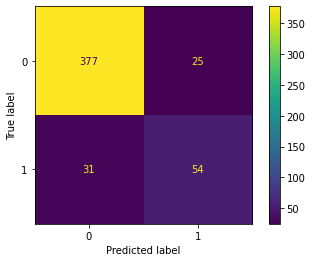

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array([res[k] for k, v in res.items() if k != 'm']).reshape(2,2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot()

In [ ]:
TP = res["TP"][0]
FP = res["FP"][0]
FN = res["FN"][0]
TN = res["TN"][0]

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2 * precision * recall) / (precision + recall)

print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")

accuracy: 0.8850102669404517, precision: 0.9378109452736318, recall: 0.9240196078431373, f1: 0.9308641975308642


---
## Cleanup! 🧹
Let's drop any of our memory-resident components before we call it quits.

In [ ]:
# Drop Any existing Graphs, Pipelines, Models...

df = gds.graph.list()
for i in df["graphName"]:
  gds.graph.get(i).drop()

df = gds.beta.pipeline.list()
for i in df["pipelineName"]:
  gds.pipeline.get(i).drop()

df = gds.beta.model.list()
for info in df["modelInfo"]:
  gds.model.get(info["modelName"]).drop()